# Selection of network depth and number of filters for the model

## Contents
* [Task description](#Task-description)
* [The parameters studied](#The-parameters-studied)
* [Parameters Value Area](#Parameters-Value-Area)
* [Metrics](#Metrics)
* [Dataset loading](#Dataset-loading)
* [Creating a cross validation object](#Creating-a-cross-validation-object)
* [Results](#Results)
* [Conclusion](#Conclusion)

## Task description
Select the architecture parameters of CNN, that predicts radial mode value. This parameters will be selected using research and cross validation method.

## The parameters studied
The order of the channels, number of initial filters, number of filters inside blocks.

## Parameters Value Area

Number of initial filters: [4, 8]

Number of filters inside blocks: [[4, 8, 16], [8, 16, 32]]

## Metrics

A percentage of items with absolute percentage error less than 30% on the test set i.e. `test_mape30`

## Dataset loading

For training and model performance assessment we use pressure derivative from wells after GRP.

Dataset consists of two parts: train (311 items) and test (90 items).

With cross validation approach we will mix all data and split it into peases for training and testing.

In [1]:
import os
import sys
sys.path.insert(0, os.path.join(".."))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from radial.batchflow import Dataset, FilesIndex, Pipeline, B, V, C
from radial.batchflow.models.tf import ResNet

from radial.batchflow.research import Research, Option
from radial.batchflow.research.research import Executable

from radial.core import RadialBatch
from radial.core.pipelines import create_preprocess_pipeline, create_train_pipeline
from radial.core.radial_batch_tools import get_mape30, save_model, get_ape
from research_utils import *
plt.style.use('ggplot')
%matplotlib inline

In [2]:
cross_val = 3
path = '/Users/anton/work/radial/research/data/*'

dataset = create_datasets(path, RadialBatch, cross_val)

## Dataset bypass:

- Define batch and grid size
- Define model config

In [3]:
N_SAMPLES = 100
B_SIZE = 50


model_config = {
    'inputs': dict(points=dict(shape=(N_SAMPLES, 2)),
                   targets=dict(name='target', shape=1)),
    'initial_block/inputs': 'points',
    'head': dict(layout='f',
                 units=1),
    'body/num_blocks': [1, 1, 1],
    'body/filters': C('body_filters'),
    'initial_block/filters': C('start_filters'),
    'loss': 'mse',
    'optimizer': 'Adam'
}

- Define a preprocessing pipeline that will be shared between train and test pipelines
- Define train and test pipeline

In [4]:
prep_pipeline = create_preprocess_pipeline(N_SAMPLES, np.random.random)
train_pipeline = create_train_pipeline(C('model'), model_config, prep_pipeline).run(B_SIZE, n_epochs=None, drop_last=True, lazy=True)

test_pipeline = prep_pipeline + (Pipeline()
                        .init_variable('predictions', init_on_each_run=list)
                        .init_variable('targets', init_on_each_run=list)
                        .import_model('model', C('import_from'))
                        .predict_model('model', fetches='predictions',
                                                feed_dict={'points': B('points'),
                                                           'targets': B('target')},
                                        save_to=B('predictions'), mode='w')
                        .denormalize(src=['predictions', 'target'], 
                                     dst=['denorm_predictions', 'denorm_target'],
                                     src_range=['derivative_q', 'derivative_q'])
                        .update_variable('predictions', B('denorm_predictions'), mode='e')
                        .update_variable('targets', B('denorm_target'), mode='e')
                        .run(B_SIZE, n_epochs=1, drop_last=True, lazy=True)
)

## Creating a cross validation object

Cross validation algorithm depend on research object, so let's configurate it.

In [5]:
opts = Option('model', [ResNet]) \
       * Option('body_filters', [[4, 8, 16],
                                 [8, 16, 32]]) * Option('start_filters', [4, 8])

research = (Research()
            .pipeline(train_pipeline, variables='loss', name='train')
            .pipeline(test_pipeline, name='test', execute='%5',
                      run=True, import_from='train')
            .grid(opts)
            .function(get_mape30, returns='metrics', name='test_log30',
                      execute='%5', pipeline='test')
            .function(get_ape, returns='metrics', name='test_ape',
                     execute=-1, pipeline='test')
            .function(save_model, execute=-1, pipeline='train',
                      model_name='model', path='saved_models/')
)

Now you can run the cross validation.

In [6]:
res = execute_research_with_cv(train_pipeline, test_pipeline, research, dataset, n_reps=3, n_iters=1500, cross_val=cross_val, dir_name='research_resnets')

## Results

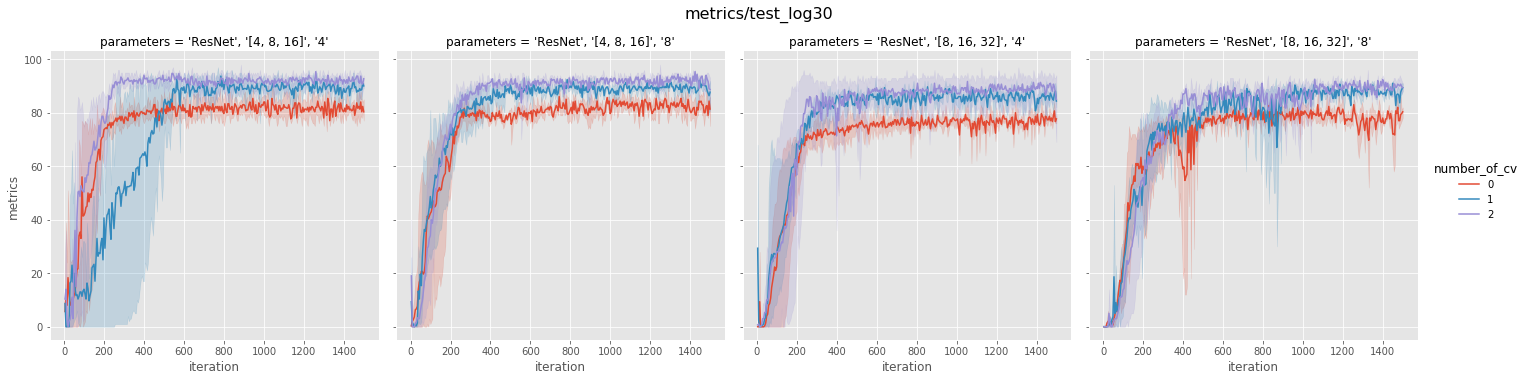

In [7]:
draw_history(research='research_resnets_3/', names=['test_log30'], types_var=['metrics'], cross_val=cross_val, aggr=False, iter_start=1, draw_dict=None)

## Conclusion

As we can see on the test_mape30 graphic, the best model is the one with parameters order of channels = (SHAPE, 2), number of filers in block - [4, 8, 16] and number of initial finters = 8.

Despite the fact that the chosen configuration of the model was on average better than others, it is useful, along with a point estimate, to obtain the distribution of the metric over N independent runs of the training procedure.

In [8]:
# измени на свои параметры
opts = Option('model', [ResNet]) * Option('body_filters', [[4, 8, 16]]) * Option('filters', [8])

research = (Research()
            .pipeline(train_pipeline, variables='loss', name='train')
            .pipeline(test_pipeline, name='test', execute='%5',
                      run=True, import_from='train')
            .grid(opts)
            .function(get_mape30, returns='metrics', name='test_mape30',
                     execute='%5', pipeline='test')
            .function(get_ape, returns='metrics', name='test_ape',
                     execute=-1, pipeline='test')
            .function(save_model, execute=-1, pipeline='train',
                      model_name='model', path='saved_models/')
)

In [9]:
NUM_REPEAT = 10
NUM_ITERS = 1200
research_name = 'model_estimation'

research.run(n_reps=NUM_REPEAT, n_iters=NUM_ITERS, name=research_name, progress_bar=True)

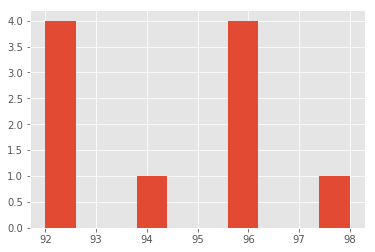

In [10]:
res_table = Research().load('model_estimation/').load_results()
all_metrics = np.array(res_table[res_table['iteration']==1199][res_table['name']=='test_mape30']['metrics'], dtype=np.float32)
plt.hist(all_metrics)
plt.show()

In [11]:
print_results(research='research_last_8/', names=['test_mape30'], types_var=['metrics'], n_last=50)

╒══════════╤═══════════════╤═══════════════════╕
│ params   │   test_mape30 │   test_mape30 std │
╞══════════╪═══════════════╪═══════════════════╡
│          │        91.932 │             0.564 │
╘══════════╧═══════════════╧═══════════════════╛
